In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.constants import k, c
import sdr_utils as sutil
import adi
from matplotlib.widgets import Slider, Button

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import scipy.signal as signal

In [11]:

## SDR Setup
sample_rate = 2e6 # Hz
center_freq = 2e9 # Hz
num_samps = 1280000
#num_samps = 128e2 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = 0 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC


In [12]:
def plot_spectrogram(title, w, fs):
    ff, tt, Sxx = signal.spectrogram(w, fs=fs, nperseg=256, nfft=576)
    plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='gray_r', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


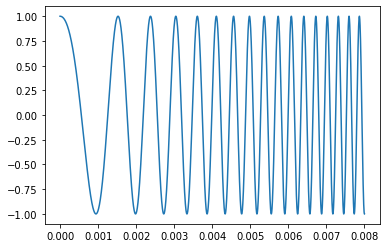

16001


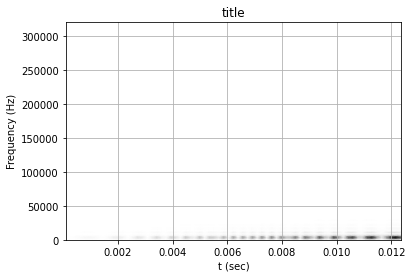

In [13]:
chirp_duration = 8e-3
Ts = 1/sample_rate
BW = 2e6 # Hz
# trying to generate a chirp 
t_range = np.arange(0, chirp_duration, Ts)
FM_chirp = signal.chirp(t_range, 325, chirp_duration, 3800, method = 'linear')

plt.plot(t_range, FM_chirp)
plt.show()
plot_spectrogram("title", FM_chirp, num_samps)

print(len(FM_chirp))

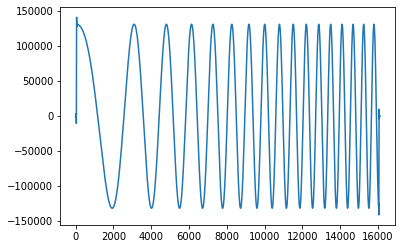

16101


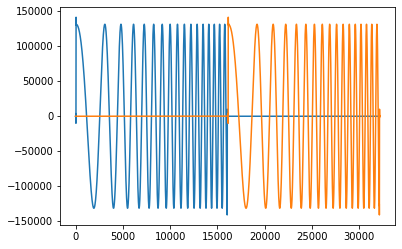

In [14]:
tx_chirp = FM_chirp * 2**14
shaped = sutil.raised_cos_filter(tx_chirp, β = 0.35)
I = shaped
Q = np.zeros(len(shaped))
IQ_send = I + 1j*Q
IQ2 = Q + 1j*I
IQ_send = np.concatenate([IQ_send, IQ2])

plt.plot(shaped)
plt.show()
print(len(shaped))

plt.plot(IQ_send.real)
plt.plot(IQ_send.imag)
plt.show()

In [52]:
# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(IQ_send) # start transmitting

sdr.rx_annotated = False

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()
print(f"rx sample size raw: {len(rx_samples)}")
# Stop transmitting
sdr.tx_destroy_buffer()

#print(rx_samples)
sdr.tx_destroy_buffer()
# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
print(np.sum(psd_dB)/1e6)

rx sample size raw: 1280000
81.78105483912935


In [16]:
m_w = (3800 - 325) / chirp_duration
def f_to_range(f):
    global c, m_w
    return f*c/(2*m_w)
f_to_range = np.vectorize(f_to_range)

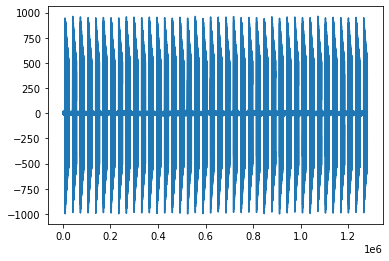

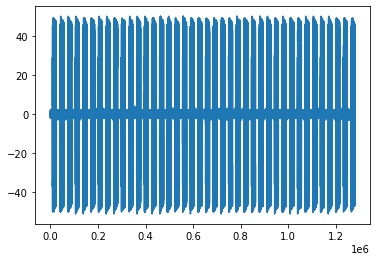

/home/gowan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


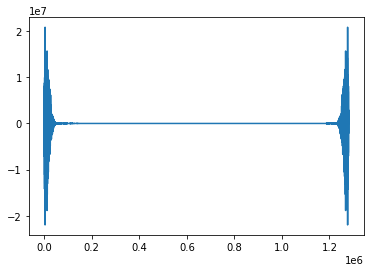

/home/gowan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


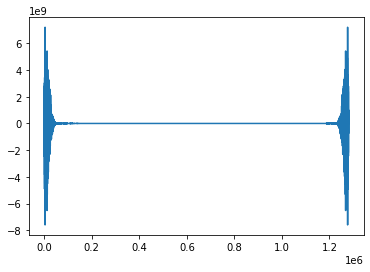

In [17]:
#from numpy.fft import fft, fftshift
from scipy.fftpack import fft, ifft
window = np.hanning(51)

data = rx_samples.real
windowed = np.convolve(window, data)
freq = fft(windowed)

plt.plot(windowed)
plt.show()


plt.plot(data)
plt.show()

plt.plot(freq)
plt.show()

plt.plot(f_to_range(freq))
plt.show()

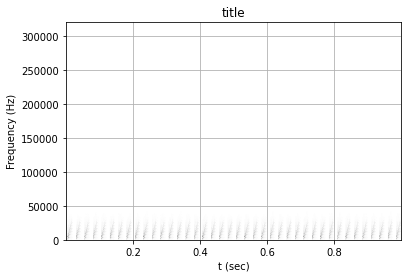

In [18]:
plot_spectrogram("title", windowed, num_samps)

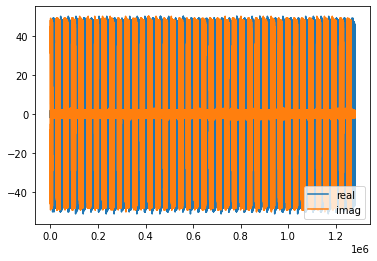

/home/gowan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


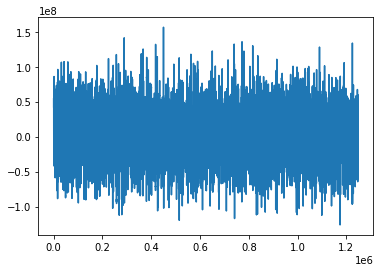

In [19]:
plt.plot(rx_samples.real)
plt.plot(rx_samples.imag)
plt.legend(["real", "imag"])
plt.show()

t = np.correlate(IQ_send, rx_samples)
plt.plot(t)
plt.show()

81746915.03086722


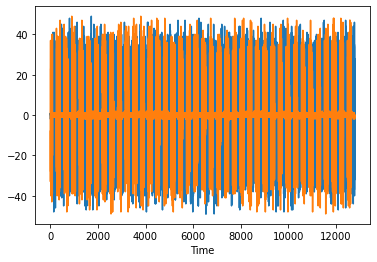

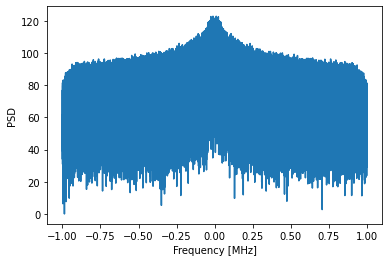

In [24]:
# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
print(np.sum(psd_dB))
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot time domain
plt.figure(0)
plt.plot(np.real(rx_samples[::100]))
plt.plot(np.imag(rx_samples[::100]))
plt.xlabel("Time")

# Plot freq domain
plt.figure(1)
plt.plot(f/1e6, psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()